# Retailer X Use Case (Data Science Bootcamp, August 14 to 16th, 2018)

This is a rewrite of the Data Science bootcamp using Python. Another one was done using SPSS

## First, get the project token to use it to access the data files

In [39]:
# @hidden_cell

Watson_Studio_Env = False

if(Watson_Studio_Env == True):
    # The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
    from project_lib import Project
    project = Project(project_id='01cb8ab3-b48d-441d-8d33-edc6caae425d', project_access_token='p-d36f9300425b2c63be8cd6c20d68a07ef91ec977')
    pc = project.project_context


## Next, load the data files

In [40]:
import pandas as pd

# Fetch the Customer file
if(Watson_Studio_Env == True):
    my_file = project.get_file("Customer Data Set - Student 1 of 3.xlsx")
    my_file.seek(0)
else:
    my_file = "Customer Data Set - Student 1 of 3.xlsx"

# Read the EXCEl data file from the object storage into a pandas DataFrame
cust_df = pd.read_excel(my_file)
print(cust_df.dtypes)
print("\nNumber of customers: {}".format(len(cust_df)))
cust_df.head()

CUSTOMER ID                  int64
GENDER                       int64
AGE                          int64
INCOME                       int64
EXPERIENCE SCORE             int64
LOYALTY GROUP               object
ENROLLMENT DATE     datetime64[ns]
HOUSEHOLD SIZE               int64
MARITAL STATUS              object
dtype: object

Number of customers: 500


,CUSTOMER ID,GENDER,AGE,INCOME,EXPERIENCE SCORE,LOYALTY GROUP,ENROLLMENT DATE,HOUSEHOLD SIZE,MARITAL STATUS
0,10001,0,64,133498,5,enrolled,2013-03-06,4,Single
1,10002,0,42,94475,9,not enrolled,NaT,6,Married
2,10003,0,40,88610,9,enrolled,2010-09-02,5,Married
3,10004,0,38,84313,8,enrolled,2015-04-06,1,Single
4,10005,0,30,51498,3,not enrolled,NaT,1,Single


In [41]:
#Next the Product file
if(Watson_Studio_Env == True):
    my_file = project.get_file("Product Data Set - Student 2 of 3.csv")
    my_file.seek(0)
else:
    my_file = "Product Data Set - Student 2 of 3.csv"

# Read the CSV data file from the object storage into a pandas DataFrame
prod_df = pd.read_csv(my_file, sep = '|')
print(prod_df.dtypes)
prod_df.head()

PRODUCT CODE          int64
PRODUCT CATEGORY     object
UNIT LIST PRICE      object
Unnamed: 3          float64
dtype: object


,PRODUCT CODE,PRODUCT CATEGORY,UNIT LIST PRICE,Unnamed: 3
0,30001,HEALTH & BEAUTY,$7.45,NaN
1,30002,HEALTH & BEAUTY,$5.35,NaN
2,30003,HEALTH & BEAUTY,$5.49,NaN
3,30004,HEALTH & BEAUTY,$6.46,NaN
4,30005,HEALTH & BEAUTY,$7.33,NaN


In [42]:
#Finally the Transcations file
if(Watson_Studio_Env == True):
    my_file = project.get_file("Transaction Data Set - Student 3 of 3.csv")
    my_file.seek(0)
else:
    my_file = "Transaction Data Set - Student 3 of 3.csv"

# Read the CSV data file from the object storage into a pandas DataFrame
trans_df = pd.read_csv(my_file, sep = '|', infer_datetime_format = True, parse_dates = [4])
print(trans_df.dtypes)
trans_df.head()

CUSTOMER NUM                   int64
PRODUCT NUM                    int64
QUANTITY PURCHASED             int64
DISCOUNT TAKEN               float64
TRANSACTION DATE      datetime64[ns]
STOCKOUT                       int64
dtype: object


,CUSTOMER NUM,PRODUCT NUM,QUANTITY PURCHASED,DISCOUNT TAKEN,TRANSACTION DATE,STOCKOUT
0,10114,30011,4,0.0,2015-01-02,0
1,10217,30016,3,0.0,2015-01-02,0
2,10224,30013,4,0.0,2015-01-02,0
3,10103,30012,3,0.2,2015-01-02,0
4,10037,30010,8,0.0,2015-01-02,0


## Feature Engineering / Data Preparation

In [43]:
# Next do some tranforms to prepare for modeling
cust_df['LOYALTY GROUP'] = cust_df['LOYALTY GROUP'].replace(('enrolled', 'not enrolled'), (1, 0))
cust_df = pd.get_dummies(cust_df, columns = ['MARITAL STATUS'])
print(cust_df.dtypes)
cust_df.head()

CUSTOMER ID                              int64
GENDER                                   int64
AGE                                      int64
INCOME                                   int64
EXPERIENCE SCORE                         int64
LOYALTY GROUP                            int64
ENROLLMENT DATE                 datetime64[ns]
HOUSEHOLD SIZE                           int64
MARITAL STATUS_Divorced                  uint8
MARITAL STATUS_Married                   uint8
MARITAL STATUS_Single                    uint8
MARITAL STATUS_Widow/Widower             uint8
dtype: object


,CUSTOMER ID,GENDER,AGE,INCOME,EXPERIENCE SCORE,LOYALTY GROUP,ENROLLMENT DATE,HOUSEHOLD SIZE,MARITAL STATUS_Divorced,MARITAL STATUS_Married,MARITAL STATUS_Single,MARITAL STATUS_Widow/Widower
0,10001,0,64,133498,5,1,2013-03-06,4,0,0,1,0
1,10002,0,42,94475,9,0,NaT,6,0,1,0,0
2,10003,0,40,88610,9,1,2010-09-02,5,0,1,0,0
3,10004,0,38,84313,8,1,2015-04-06,1,0,0,1,0
4,10005,0,30,51498,3,0,NaT,1,0,0,1,0


In [44]:
# Make price a float
prod_df.drop('Unnamed: 3', axis=1, inplace=True)
prod_df.dtypes
prod_df['UNIT LIST PRICE'] = prod_df['UNIT LIST PRICE'].replace('\$', '', regex=True)
prod_df['UNIT LIST PRICE'] = prod_df['UNIT LIST PRICE'].astype('float')
print(prod_df.dtypes)
prod_df.head()

PRODUCT CODE          int64
PRODUCT CATEGORY     object
UNIT LIST PRICE     float64
dtype: object


,PRODUCT CODE,PRODUCT CATEGORY,UNIT LIST PRICE
0,30001,HEALTH & BEAUTY,7.45
1,30002,HEALTH & BEAUTY,5.35
2,30003,HEALTH & BEAUTY,5.49
3,30004,HEALTH & BEAUTY,6.46
4,30005,HEALTH & BEAUTY,7.33


In [45]:
# rename product key in trans dataframe
trans_df.rename(columns={'PRODUCT NUM': 'PRODUCT CODE', 'CUSTOMER NUM': 'CUSTOMER ID'}, inplace=True)

# Get product category and unit price and add them to the transaction table
trans_df2 = trans_df.merge(prod_df, on = 'PRODUCT CODE', how='inner')
trans_df2 # this is a new dataframe, changing a value in trans_df2 will not change it in trans_df

# Calculate Transaction total
trans_df2['TRANSACTION TOTAL'] = trans_df2['QUANTITY PURCHASED'] * trans_df2['UNIT LIST PRICE'] * (1 - trans_df2['DISCOUNT TAKEN'])
trans_df2.head()

# Transform PRODUCT CATEGORY to flag
trans_df2 = pd.get_dummies(trans_df2, columns = ['PRODUCT CATEGORY'])

# Add DISCOUNT FLAG column
trans_df2['DISCOUNT FLAG'] = trans_df2['DISCOUNT TAKEN']
trans_df2.loc[trans_df2['DISCOUNT FLAG'] > 0, 'DISCOUNT FLAG'] = 1

trans_df2

# Aggregate on CUSTOMER ID

,CUSTOMER ID,PRODUCT CODE,QUANTITY PURCHASED,DISCOUNT TAKEN,TRANSACTION DATE,STOCKOUT,UNIT LIST PRICE,TRANSACTION TOTAL,PRODUCT CATEGORY_APPAREL,PRODUCT CATEGORY_ELECTRONICS,PRODUCT CATEGORY_FOOD,PRODUCT CATEGORY_HEALTH & BEAUTY,DISCOUNT FLAG
0,10114,30011,4,0.0,2015-01-02,0,25.46,101.840,1,0,0,0,0.0
1,10086,30011,6,0.0,2015-01-02,0,25.46,152.760,1,0,0,0,0.0
2,10174,30011,10,0.0,2015-01-02,0,25.46,254.600,1,0,0,0,0.0
3,10401,30011,12,0.0,2015-01-02,0,25.46,305.520,1,0,0,0,0.0
4,10216,30011,12,0.1,2015-01-02,0,25.46,274.968,1,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,10325,30003,9,0.0,2015-12-11,0,5.49,49.410,0,0,0,1,0.0
9996,10072,30003,8,0.0,2015-12-15,0,5.49,43.920,0,0,0,1,0.0
9997,10337,30003,7,0.0,2015-12-29,0,5.49,38.430,0,0,0,1,0.0
9998,10378,30003,9,0.0,2015-12-30,0,5.49,49.410,0,0,0,1,0.0


In [46]:
pd.set_option('display.width', 3000)
pd.set_option('display.max.columns', 500)
pd.set_option('display.max.rows', 20)

grouped = trans_df2.groupby(['CUSTOMER ID']).agg(['sum', 'mean', 'max', 'count'])
grouped = grouped.reset_index()
type(grouped.columns)
grouped.columns = grouped.columns.map('_'.join)
grouped.columns.values[0] = 'CUSTOMER ID'

grouped.dtypes

CUSTOMER ID                                 int64
PRODUCT CODE_sum                            int64
PRODUCT CODE_mean                         float64
PRODUCT CODE_max                            int64
PRODUCT CODE_count                          int64
                                           ...   
PRODUCT CATEGORY_HEALTH & BEAUTY_count      int64
DISCOUNT FLAG_sum                         float64
DISCOUNT FLAG_mean                        float64
DISCOUNT FLAG_max                         float64
DISCOUNT FLAG_count                         int64
Length: 45, dtype: object

In [47]:
cust_df2 = cust_df.merge(grouped, on = 'CUSTOMER ID', how='inner')

columns_to_keep = ['CUSTOMER ID', 'GENDER' , 'AGE', 'INCOME', 'EXPERIENCE SCORE', 'LOYALTY GROUP', 'ENROLLMENT DATE', 'HOUSEHOLD SIZE', 
                   'MARITAL STATUS_Divorced', 'MARITAL STATUS_Married', 'MARITAL STATUS_Single', 'MARITAL STATUS_Widow/Widower', 
                   'QUANTITY PURCHASED_sum', 'QUANTITY PURCHASED_mean', 
                   'DISCOUNT TAKEN_max', 'DISCOUNT TAKEN_mean',
                   'DISCOUNT FLAG_max', 'DISCOUNT FLAG_sum',
                   'TRANSACTION TOTAL_sum', 'TRANSACTION TOTAL_mean', 'TRANSACTION TOTAL_count', 
                   'PRODUCT CATEGORY_APPAREL_max', 'PRODUCT CATEGORY_ELECTRONICS_max', 'PRODUCT CATEGORY_FOOD_max', 'PRODUCT CATEGORY_HEALTH & BEAUTY_max']

cust_df2 = cust_df2[columns_to_keep]
cust_df2

,CUSTOMER ID,GENDER,AGE,INCOME,EXPERIENCE SCORE,LOYALTY GROUP,ENROLLMENT DATE,HOUSEHOLD SIZE,MARITAL STATUS_Divorced,MARITAL STATUS_Married,MARITAL STATUS_Single,MARITAL STATUS_Widow/Widower,QUANTITY PURCHASED_sum,QUANTITY PURCHASED_mean,DISCOUNT TAKEN_max,DISCOUNT TAKEN_mean,DISCOUNT FLAG_max,DISCOUNT FLAG_sum,TRANSACTION TOTAL_sum,TRANSACTION TOTAL_mean,TRANSACTION TOTAL_count,PRODUCT CATEGORY_APPAREL_max,PRODUCT CATEGORY_ELECTRONICS_max,PRODUCT CATEGORY_FOOD_max,PRODUCT CATEGORY_HEALTH & BEAUTY_max
0,10001,0,64,133498,5,1,2013-03-06,4,0,0,1,0,396,14.666667,0.4,0.111111,1.0,13.0,6826.770,252.843333,27,1,1,1,1
1,10002,0,42,94475,9,0,NaT,6,0,1,0,0,202,8.416667,0.5,0.112500,1.0,9.0,5062.451,210.935458,24,1,1,1,0
2,10003,0,40,88610,9,1,2010-09-02,5,0,1,0,0,265,11.521739,0.3,0.043478,1.0,4.0,8562.440,372.280000,23,1,1,1,0
3,10004,0,38,84313,8,1,2015-04-06,1,0,0,1,0,197,10.368421,0.3,0.100000,1.0,8.0,5522.694,290.668105,19,1,1,1,0
4,10005,0,30,51498,3,0,NaT,1,0,0,1,0,12,6.000000,0.4,0.350000,1.0,2.0,213.512,106.756000,2,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,10496,0,47,113125,7,1,2014-01-23,2,0,0,1,0,309,13.434783,0.3,0.060870,1.0,7.0,8501.464,369.628870,23,1,1,1,1
496,10497,0,49,118108,7,1,2007-10-01,1,0,0,1,0,360,13.333333,0.5,0.096296,1.0,10.0,9903.658,366.802148,27,1,1,1,1
497,10498,0,42,97353,8,1,2009-05-21,5,0,1,0,0,337,11.620690,0.3,0.041379,1.0,8.0,6251.466,215.567793,29,1,1,1,1
498,10499,1,22,34424,1,0,NaT,2,0,0,1,0,3,1.500000,0.0,0.000000,0.0,0.0,20.010,10.005000,2,0,0,0,1


## Feature Selection

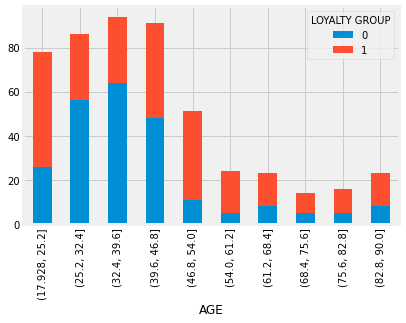

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline
bins = pd.cut(cust_df2['AGE'], bins = 10)
tab = pd.crosstab(bins, cust_df2['LOYALTY GROUP'],margins=True)
tab = tab.drop('All',axis=1)
tab = tab.drop('All',axis=0)
tab.plot(kind='bar', stacked = True)
plt.show()

In [49]:
numeric_features = ['AGE', 'INCOME', 'EXPERIENCE SCORE', 'HOUSEHOLD SIZE', 
                    'QUANTITY PURCHASED_sum', 'QUANTITY PURCHASED_mean', 
                    'TRANSACTION TOTAL_sum', 'TRANSACTION TOTAL_mean', 'TRANSACTION TOTAL_count']
cust_df2[numeric_features].corr()

,AGE,INCOME,EXPERIENCE SCORE,HOUSEHOLD SIZE,QUANTITY PURCHASED_sum,QUANTITY PURCHASED_mean,TRANSACTION TOTAL_sum,TRANSACTION TOTAL_mean,TRANSACTION TOTAL_count
AGE,1.000000,0.941799,0.063957,0.029117,0.694876,0.850227,0.576017,0.648537,0.148925
INCOME,0.941799,1.000000,0.035139,0.143772,0.735721,0.892511,0.688031,0.776399,0.178980
EXPERIENCE SCORE,0.063957,0.035139,1.000000,-0.056569,0.183007,0.177476,0.136564,0.105325,0.105089
HOUSEHOLD SIZE,0.029117,0.143772,-0.056569,1.000000,0.171280,0.106077,0.251744,0.203744,0.197516
QUANTITY PURCHASED_sum,0.694876,0.735721,0.183007,0.171280,1.000000,0.829303,0.869524,0.656066,0.674032
QUANTITY PURCHASED_mean,0.850227,0.892511,0.177476,0.106077,0.829303,1.000000,0.724786,0.807722,0.216816
TRANSACTION TOTAL_sum,0.576017,0.688031,0.136564,0.251744,0.869524,0.724786,1.000000,0.851646,0.587092
TRANSACTION TOTAL_mean,0.648537,0.776399,0.105325,0.203744,0.656066,0.807722,0.851646,1.000000,0.171487
TRANSACTION TOTAL_count,0.148925,0.178980,0.105089,0.197516,0.674032,0.216816,0.587092,0.171487,1.000000


In [57]:
# Feature Extraction with Univariate Statistical Tests (Chi-squared for classification)
pd.set_option('display.expand_frame_repr', False)
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
# load data

features = ['AGE', 'INCOME', 'EXPERIENCE SCORE', 'HOUSEHOLD SIZE', 
            'MARITAL STATUS_Divorced', 'MARITAL STATUS_Married', 'MARITAL STATUS_Single', 'MARITAL STATUS_Widow/Widower', 
            'QUANTITY PURCHASED_sum', 
            'DISCOUNT FLAG_max', 'DISCOUNT FLAG_sum', 
            'TRANSACTION TOTAL_sum', 
            'PRODUCT CATEGORY_APPAREL_max', 'PRODUCT CATEGORY_ELECTRONICS_max', 'PRODUCT CATEGORY_FOOD_max', 'PRODUCT CATEGORY_HEALTH & BEAUTY_max']

target = 'LOYALTY GROUP'

X = cust_df2[features]
Y = cust_df2[target]

# feature extraction
test = SelectKBest(score_func=chi2, k=6)
fit = test.fit(X, Y)

# summarize scores
np.set_printoptions(precision=3, suppress=True)
print(fit.scores_)

features = fit.transform(X)
selected_feature_names = X.columns[fit.get_support()]
print(selected_feature_names)

# get the array of observations for top features, NICE!!
features_df = pd.DataFrame(features)
features_df

[    76.61  145911.162     63.51       0.137      2.231      0.137
      0.021      0.076   5487.102     37.663    319.569  96208.238
      0.062      0.012      0.041      9.443]
Index(['AGE', 'INCOME', 'EXPERIENCE SCORE', 'QUANTITY PURCHASED_sum', 'DISCOUNT FLAG_sum', 'TRANSACTION TOTAL_sum'], dtype='object')


,0,1,2,3,4,5
0,64.0,133498.0,5.0,396.0,13.0,6826.770
1,42.0,94475.0,9.0,202.0,9.0,5062.451
2,40.0,88610.0,9.0,265.0,4.0,8562.440
3,38.0,84313.0,8.0,197.0,8.0,5522.694
4,30.0,51498.0,3.0,12.0,2.0,213.512
...,...,...,...,...,...,...
495,47.0,113125.0,7.0,309.0,7.0,8501.464
496,49.0,118108.0,7.0,360.0,10.0,9903.658
497,42.0,97353.0,8.0,337.0,8.0,6251.466
498,22.0,34424.0,1.0,3.0,0.0,20.010


## Feature Scaling

In [51]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler

#features = ['GENDER' , 'AGE', 'INCOME', 'EXPERIENCE SCORE', 'HOUSEHOLD SIZE', 
#            'MARITAL STATUS_Divorced', 'MARITAL STATUS_Married', 'MARITAL STATUS_Single', 'MARITAL STATUS_Widow/Widower', 
#            'QUANTITY PURCHASED_sum', 'QUANTITY PURCHASED_mean', 
#            'DISCOUNT FLAG_max', 
#            'TRANSACTION TOTAL_sum', 'TRANSACTION TOTAL_mean', 
#            'PRODUCT CATEGORY_APPAREL_max', 'PRODUCT CATEGORY_ELECTRONICS_max', 'PRODUCT CATEGORY_FOOD_max', 'PRODUCT CATEGORY_HEALTH & BEAUTY_max']

features = ['AGE', 'INCOME', 'EXPERIENCE SCORE', 'DISCOUNT FLAG_sum', 'QUANTITY PURCHASED_sum', 'TRANSACTION TOTAL_sum']
target = 'LOYALTY GROUP'

# ALWAYS SPLIT FIRST BEFORE SCALING TO AVOID PREDICTOR LEAKAGE !!!!!
X = cust_df2[features]
y = cust_df2[target]

#Train Test Split, reserve test subset for finally accuracy and other metrics calculations
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(X_train) # fit the scaler on training data then apply to training and test data
X_train = scaler.transform(X_train)
X_test =  scaler.transform(X_test)
print('Done')

Done


## Trying Different Models

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

# using specific random state to make sure we always get same accuracy result if we execute this cell multiple times or on multiple machines

logreg = LogisticRegression(random_state=1)
# 10-fold cross-validation, calculating average training accuracy
scores = cross_val_score(logreg, X_train, y_train, cv=5, scoring='accuracy')
print("Logistic regression accuracy is:", scores.mean())

svc = svm.SVC(random_state=1)
# 10-fold cross-validation, calculating average training accuracy
scores = cross_val_score(svc, X_train, y_train, cv=5, scoring='accuracy')
print("SVM accuracy is: ", scores.mean())

rc = RandomForestClassifier(random_state=1)
# 10-fold cross-validation, calculating average training accuracy
scores = cross_val_score(rc, X_train, y_train, cv=5, scoring='accuracy')
print("Random forest accuracy is: ", scores.mean())

Logistic regression accuracy is: 0.8171428571428573
SVM accuracy is:  0.8742857142857142
Random forest accuracy is:  0.8885714285714286


# Use Random Search Cross Validation to fine tune the selected model hyperparameters

In [53]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

#C_options = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
#solver_options = ['newton-cg', 'lbfgs', 'liblinear', 'sag']
#multi_class_options = ['ovr']
#class_weight_options = [None, 'balanced']
#param_grid = dict(C = C_options)

#clf = GridSearchCV(LogisticRegression(), param_grid)

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)] # Number of trees in random forest
max_features = ['auto', 'sqrt'] # Number of features to consider at every split
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)] # Maximum number of levels in tree
max_depth.append(None)
min_samples_split = [2, 5, 10] # Minimum number of samples required to split a node
min_samples_leaf = [1, 2, 4] # Minimum number of samples required at each leaf node
bootstrap = [True, False] # Method of selecting samples for training each tree

# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

clf = RandomizedSearchCV(RandomForestClassifier(random_state = 1), param_grid, random_state=1)
clf.fit(X_train, y_train)
best_model = clf.best_estimator_
best_model

RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=1200, random_state=1)

## Use the tuned model to find testing accuracy

In [54]:
y_pred = best_model.predict(X_test)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

print('\nAccuracy of tuned model on test set: {}\n'.format(best_model.score(X_test, y_test)))

print(classification_report(y_test, y_pred))

[[59 15]
 [ 7 69]]

Accuracy of tuned model on test set: 0.8533333333333334

              precision    recall  f1-score   support

           0       0.89      0.80      0.84        74
           1       0.82      0.91      0.86        76

    accuracy                           0.85       150
   macro avg       0.86      0.85      0.85       150
weighted avg       0.86      0.85      0.85       150



## Displaying the modeling predictors sorted by importance

In [55]:
import pandas as pd

# model is the trained model
importances = best_model.feature_importances_

# Extract the feature importances into a dataframe
feature_results = pd.DataFrame({'feature': features, 
                                'importance': importances})

# Show the top 10 most important
feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)

feature_results.head(10)


,feature,importance
0,DISCOUNT FLAG_sum,0.287377
1,QUANTITY PURCHASED_sum,0.232531
2,EXPERIENCE SCORE,0.154096
3,TRANSACTION TOTAL_sum,0.123360
4,INCOME,0.113979
5,AGE,0.088656


<Figure size 864x432 with 0 Axes>

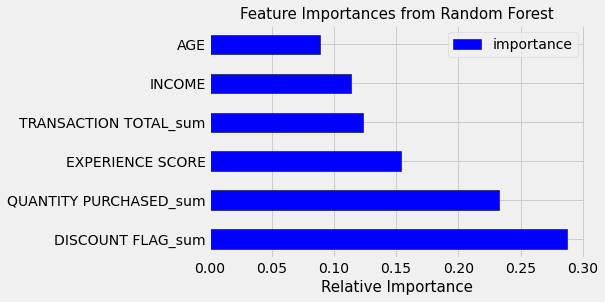

In [56]:
plt.figure(figsize=(12, 6))
plt.style.use('fivethirtyeight')

# Plot the 10 most important features in a horizontal bar chart
feature_results.loc[:9, :].plot(x = 'feature', y = 'importance', 
                                 edgecolor = 'k',
                                 kind='barh', color = 'blue')
plt.xlabel('Relative Importance', size = 15)
plt.ylabel('')
plt.title('Feature Importances from Random Forest', size = 15)
plt.show()
